In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report

# Best models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
import joblib

# Load saved feature sets
X_train = joblib.load("X_train_smote.pkl")
y_train = joblib.load("y_train_smote.pkl")
X_test = joblib.load("X_test.pkl")
y_test = joblib.load("y_test.pkl")

## 1. Retrain and Reload Final Models

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Baseline Logistic Regression
model_logistic = LogisticRegression(max_iter=1000, random_state=42)
model_logistic.fit(X_train, y_train)

# Tuned Random Forest
model_rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

# Tuned XGBoost
model_xgb = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, eval_metric='logloss', random_state=42, n_jobs=-1)
model_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

## 2. Plot ROC Curves Side-by-Side

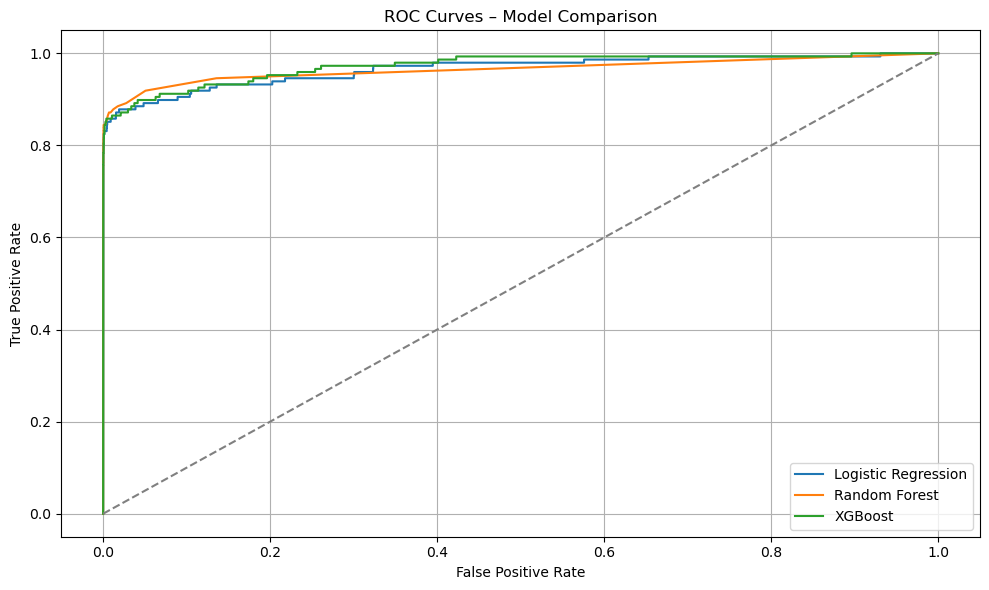

In [4]:
# Get predicted probabilities
logistic_probs = model_logistic.predict_proba(X_test)[:, 1]
rf_probs       = model_rf.predict_proba(X_test)[:, 1]
xgb_probs      = model_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test, logistic_probs)
fpr_rf, tpr_rf, _    = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _  = roc_curve(y_test, xgb_probs)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Model Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
from sklearn.metrics import roc_auc_score

print("ROC-AUC Scores:")
print("Logistic Regression:", roc_auc_score(y_test, logistic_probs))
print("Random Forest      :", roc_auc_score(y_test, rf_probs))
print("XGBoost            :", roc_auc_score(y_test, xgb_probs))

ROC-AUC Scores:
Logistic Regression: 0.9660304539254068
Random Forest      : 0.9652455389324491
XGBoost            : 0.9728013111886727


## 3. Confusion Matrix Analysis

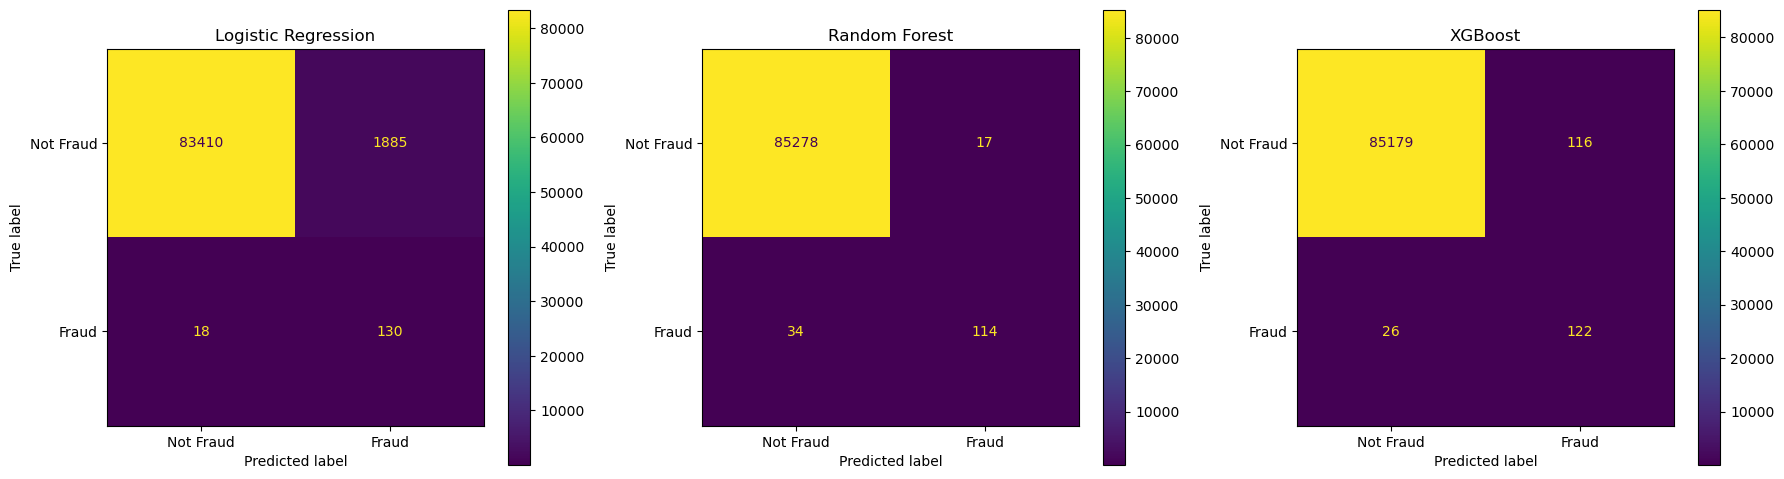

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred_log = model_logistic.predict(X_test)
y_pred_rf  = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_log), display_labels=["Not Fraud", "Fraud"]).plot(ax=axs[0], values_format='d')
axs[0].set_title("Logistic Regression")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=["Not Fraud", "Fraud"]).plot(ax=axs[1], values_format='d')
axs[1].set_title("Random Forest")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb), display_labels=["Not Fraud", "Fraud"]).plot(ax=axs[2], values_format='d')
axs[2].set_title("XGBoost")

plt.tight_layout()
plt.show()

The confusion matrices below illustrate the classification results of each model on the original (imbalanced) test set. These are particularly important in fraud detection, where:

- **False Negatives (bottom-left)** represent fraud cases that were missed — a critical failure in this domain.
- **False Positives (top-right)** are legitimate transactions incorrectly flagged as fraud — causing inconvenience to customers.

A strong fraud detection model aims to minimize **both**, with particular emphasis on reducing false negatives without overwhelming the system with false alerts.

## 4. Score Comparison Table

In [6]:
from sklearn.metrics import classification_report

# Get full reports
report_log = classification_report(y_test, model_logistic.predict(X_test), output_dict=True)
report_rf  = classification_report(y_test, model_rf.predict(X_test), output_dict=True)
report_xgb = classification_report(y_test, model_xgb.predict(X_test), output_dict=True)

# Build DataFrame
comparison_df = pd.DataFrame({
    'Logistic Regression': {
        'Precision (fraud)': report_log['1']['precision'],
        'Recall (fraud)':    report_log['1']['recall'],
        'F1-score (fraud)':  report_log['1']['f1-score'],
        'ROC-AUC':           roc_auc_score(y_test, logistic_probs)
    },
    'Random Forest': {
        'Precision (fraud)': report_rf['1']['precision'],
        'Recall (fraud)':    report_rf['1']['recall'],
        'F1-score (fraud)':  report_rf['1']['f1-score'],
        'ROC-AUC':           roc_auc_score(y_test, rf_probs)
    },
    'XGBoost': {
        'Precision (fraud)': report_xgb['1']['precision'],
        'Recall (fraud)':    report_xgb['1']['recall'],
        'F1-score (fraud)':  report_xgb['1']['f1-score'],
        'ROC-AUC':           roc_auc_score(y_test, xgb_probs)
    }
})

# Transpose for better view
comparison_df = comparison_df.T.round(4)
comparison_df

,Precision (fraud),Recall (fraud),F1-score (fraud),ROC-AUC
Logistic Regression,0.0645,0.8784,0.1202,0.9660
Random Forest,0.8702,0.7703,0.8172,0.9652
XGBoost,0.5126,0.8243,0.6321,0.9728


## 5. Final Model Comparison Summary

This notebook compares the performance of three classification models on the credit card fraud detection dataset. The models were trained using SMOTE-balanced data and evaluated on the original, imbalanced test set to reflect real-world conditions.

### Key Evaluation Metrics (Fraud Class - Label = 1)

- **Logistic Regression**
  - Precision: 0.0645
  - Recall: 0.8784
  - F1-score: 0.1202
  - ROC-AUC: 0.9660

- **Random Forest**
  - Precision: 0.8702
  - Recall: 0.7703
  - F1-score: 0.8172
  - ROC-AUC: 0.9652

- **XGBoost**
  - Precision: 0.5126
  - Recall: 0.8243
  - F1-score: 0.6321
  - ROC-AUC: 0.9728

### Interpretation

- **Logistic Regression** achieved high recall but extremely low precision, identifying most frauds but with many false alarms.
- **Random Forest** delivered the best balance between precision and recall, with the highest F1-score — indicating it is both accurate and consistent.
- **XGBoost** attained the best ROC-AUC score and recall, showing strong potential in ranking predictions, though with slightly lower precision than Random Forest.

### Recommendation

**Random Forest** is the most well-rounded and reliable model in this scenario. It balances fraud detection accuracy with fewer false positives, making it a strong candidate for production deployment.

**XGBoost** is a powerful alternative when maximizing fraud detection is prioritized over minimizing false positives.

### Project Notes

- **Feature Engineering** and **preprocessing** were handled in a dedicated notebook and serialized for reuse.
- **Class Imbalance** was addressed using SMOTE, applied only to the training set.
- Models were evaluated using **classification reports**, **confusion matrices**, and **ROC-AUC curves**.
- Hyperparameter tuning was performed using **GridSearchCV** with cross-validation to optimize performance.
